In [2]:
import numpy as np
import datetime as dt
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import dask
dask.config.set(scheduler='synchronous')
#from dask.distributed import Client, LocalCluster
#cluster = LocalCluster(processes=True)
#client = Client(cluster)  # memory_limit='16GB', 

import xarray as xr
from dask.diagnostics import ProgressBar

In [3]:
import sys
print(sys.executable)

/home/srvx11/lehre/users/a1254888/.conda/envs/ml_flood2/bin/python3


In [4]:
def shift_time(ds, value):
    ds.coords['time'].values = pd.to_datetime(ds.coords['time'].values) + value
    return ds

In [5]:
static = xr.open_dataset('../data/danube/era5_slt_z_slor_lsm_stationary_field.nc')
static

<xarray.Dataset>
Dimensions:    (latitude: 13, longitude: 53, time: 31)
Coordinates:
  * longitude  (longitude) float32 7.0 7.25 7.5 7.75 ... 19.25 19.5 19.75 20.0
  * latitude   (latitude) float32 50.0 49.75 49.5 49.25 ... 47.5 47.25 47.0
  * time       (time) datetime64[ns] 2000-01-01T23:00:00 ... 2000-01-31T23:00:00
Data variables:
    slt        (time, latitude, longitude) float32 ...
    z          (time, latitude, longitude) float32 ...
    slor       (time, latitude, longitude) float32 ...
    lsm        (time, latitude, longitude) float32 ...
Attributes:
    CDI:          Climate Data Interface version 1.6.4rc4 (http://code.zmaw.d...
    Conventions:  CF-1.6
    history:      Thu May 30 01:39:36 2019: cdo dayavg /home/srvx11/lehre/use...
    CDO:          Climate Data Operators version 1.6.4rc7 (http://code.zmaw.d...

In [6]:
glofas = xr.open_dataset('../data/danube/glofas_reanalysis_danube_1981-2002.nc')
glofas = glofas.rename({'lat': 'latitude', 'lon': 'longitude'})  # to have the same name like in era5
glofas = shift_time(glofas, -dt.timedelta(days=1))

In [7]:
z_glofas = static['z'].isel(time=0)/9.81  # converting to m approx.
z_glofas = z_glofas.interp(latitude=glofas.latitude,
                           longitude=glofas.longitude)

In [8]:
dis = glofas['dis']
dis

<xarray.DataArray 'dis' (time: 8035, latitude: 30, longitude: 130)>
[31336500 values with dtype=float32]
Coordinates:
  * longitude  (longitude) float64 7.05 7.15 7.25 7.35 ... 19.75 19.85 19.95
  * latitude   (latitude) float64 49.95 49.85 49.75 49.65 ... 47.25 47.15 47.05
  * time       (time) datetime64[ns] 1981-01-01 1981-01-02 ... 2002-12-31
Attributes:
    long_name:  discharge
    units:      m3/s

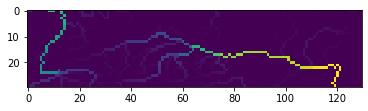

In [12]:
plt.imshow(dis.mean('time').values)

In [23]:
a = dis.mean('time').values[:,110]
print(np.where(a==a.max()))
# (22, 110) is gridpoint of river and quite large

(array([22]),)


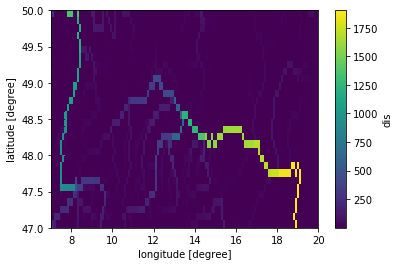

In [42]:
dis.mean('time').plot()

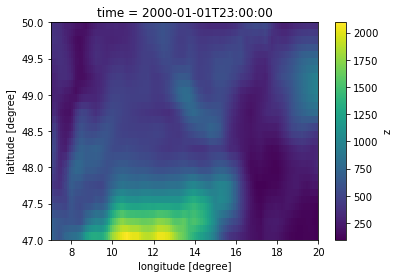

In [47]:
z_glofas.plot()

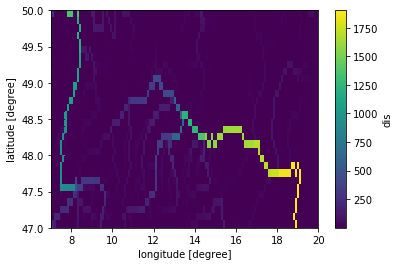

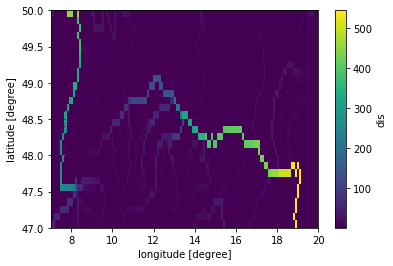

In [67]:
meandis = dis.mean('time')
meandis.plot()

plt.figure()
mindis = dis.min('time')
mindis.plot()

### which gridpoints are definitely no rivers?

Text(0.5, 1.0, 'discharge > 5 m^3/s')

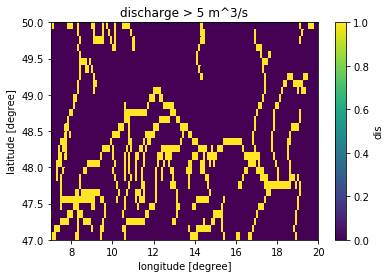

In [68]:
river = dis.min('time') > 5
river.plot.pcolormesh()
plt.title('discharge > 5 m^3/s')

13 36


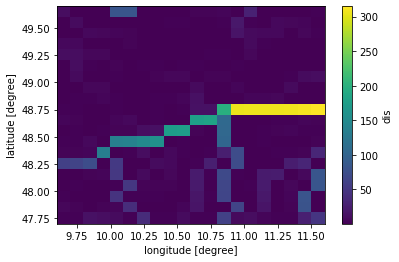

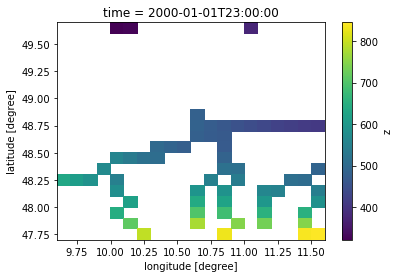

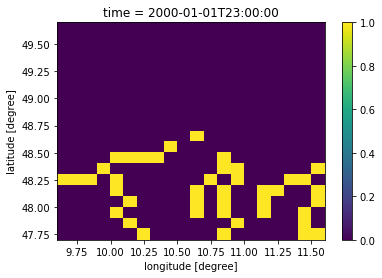

In [79]:
di = 10
dj = 10
pct = 0.1  # influencing gridpoint must have mean discharge more than this percentage

#for i in range(di, len(dis.latitude)-dj):
#    for j in range(dj, len(dis.longitude)-dj):
got = False


while not got:
    i = np.random.choice(range(di, len(dis.latitude)-dj))
    j = np.random.choice(range(dj, len(dis.longitude)-dj))
    got = river[i,j]

if river[i,j] == 1:
    print(i,j)
    
    i0, i1 = i-di, i+di
    j0, j1 = j-dj, j+dj
    dis_box = meandis[i0:i1,j0:j1]
    z_box = z_glofas[i0:i1,j0:j1]

    fig, ax = plt.subplots()
    dis_box.plot()
    fig, ax = plt.subplots()
    z_box.where(river==1).plot()

    # select feature gridpoints
    fig, ax = plt.subplots()
    influencer = (dis_box > pct*meandis[i,j])  \
                  &(z_box >= z_glofas[i,j])   \
                  &(river==1)
    influencer.plot()

    # plot center point

#    break